# Applying Machine Learning to Sentiment Analysis

## Obtaining the IMDb movie review dataset

The IMDB movie review set can be downloaded from [http://ai.stanford.edu/~amaas/data/sentiment/](http://ai.stanford.edu/~amaas/data/sentiment/).
After downloading the dataset, decompress the files.

In [1]:
# Get the files
! wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2024-11-12 21:15:43--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  26.3MB/s    in 3.2s    

2024-11-12 21:15:46 (25.1 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [2]:
# Decrompress the files
! tar -zxf aclImdb_v1.tar.gz

In [3]:
# Load file folders for training data using sklearn's load_files
from sklearn.datasets import load_files

# load_files returns a bunch, containing training texts and training labels
reviews_train = load_files("aclImdb/train")

text_train, y_train = reviews_train.data, reviews_train.target

print("type of text_train: {}".format(type(text_train)))
print("length of text_train: {}".format(len(text_train)))
print("text_train[6]:\n{}".format(text_train[6]))

type of text_train: <class 'list'>
length of text_train: 75000
text_train[6]:
b'Gloomy Sunday - Ein Lied von Liebe und Tod directed by Rolf Sch\xc3\xbcbel in 1999 is a romantic, absorbing, beautiful, and heartbreaking movie. It started like Jules and Jim; it ended as one of Agatha Christie\'s books, and in between it said something about love, friendship, devotion, jealousy, war, Holocaust, dignity, and betrayal, and it did better than The Black Book which is much more popular. It is not perfect, and it made me, a cynic, wonder in the end on the complexity of the relationships and sensational revelations, and who is who to whom but the movie simply overwhelmed me. Perfect or not, it is unforgettable. All four actors as the parts of the tragic not even a triangle but a rectangle were terrific. I do believe that three men could fell deeply for one girl as beautiful and dignified as Ilona in a star-making performance by young Hungarian actress Erica Marozs\xc3\xa1n and who would not? The 

In [4]:
# Clean up html in byte data
text_train = [doc.replace(b"<br />", b" ") for doc in text_train]

In [5]:
# Install pyprind (progress bar indicator)
! pip install pyprind

In [6]:
# Pull the data into a dataframe
import pyprind
import numpy as np
import pandas as pd
import os

# change the `basepath` to the directory of the # unzipped movie dataset
basepath = 'aclImdb'

labels = {'pos': 1, 'neg': 0}
pbar = pyprind.ProgBar(50000)
df = pd.DataFrame()
for s in ('test', 'train'):
    for l in ('pos', 'neg'):
        path = os.path.join(basepath, s, l)
        for file in os.listdir(path):
            with open(os.path.join(path, file), 'r') as infile:
                txt = infile.read()
            # df = df.append([[txt, labels[l]]], ignore_index=True)
            df = pd.concat([df, pd.DataFrame({'review':txt, 'sentiment':labels[l]}, index=[0])])
            pbar.update()
df = df.reset_index(drop=True)

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:22


In [7]:
# Inspect the data

display(df.head())
print(df['sentiment'].value_counts())

,review,sentiment
0,This movie stands for entertanment. Its the fu...,1
1,"If there's one good suspenseful film, this is ...",1
2,"I just want to comment to the woman above, tha...",1
3,"**1/2 Elisha Cuthbert, Chad Michael Murray, Br...",1
4,(Spoilers warning) I cannot say enough good th...,1


sentiment
1    25000
0    25000
Name: count, dtype: int64


## Transforming documents into feature vectors

By calling the fit_transform method on CountVectorizer, we construct the vocabulary of the bag-of-words model and transformed the following three sentences into sparse feature vectors:
1. The sun is shining
2. The weather is sweet
3. The sun is shining, the weather is sweet, and one and one is two


In [8]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer()
docs = np.array([
        'The sun is shining',
        'The weather is sweet',
        'The sun is shining, the weather is sweet, and one and one is two'])
bag = count.fit_transform(docs)

Now let us print the contents of the vocabulary to get a better understanding of the underlying concepts:

In [9]:
print(count.vocabulary_)

{'the': 6, 'sun': 4, 'is': 1, 'shining': 3, 'weather': 8, 'sweet': 5, 'and': 0, 'one': 2, 'two': 7}


As we can see from executing the preceding command, the vocabulary is stored in a Python dictionary, which maps the unique words that are mapped to integer indices. Next let us print the feature vectors that we just created:

In [10]:
count.get_feature_names_out() # feature names in alphabetical order

array(['and', 'is', 'one', 'shining', 'sun', 'sweet', 'the', 'two',
       'weather'], dtype=object)

Each index position in the feature vectors shown here corresponds to the integer values that are stored as dictionary items in the CountVectorizer vocabulary.



In [11]:
print(bag) # The bagged data counts the frequency of each term in each document.
           # Nonzero data is included, which uses less memory

  (0, 6)	1
  (0, 4)	1
  (0, 1)	1
  (0, 3)	1
  (1, 6)	1
  (1, 1)	1
  (1, 8)	1
  (1, 5)	1
  (2, 6)	2
  (2, 4)	1
  (2, 1)	3
  (2, 3)	1
  (2, 8)	1
  (2, 5)	1
  (2, 0)	2
  (2, 2)	2
  (2, 7)	1


In [12]:
# We can convert bag values to a term document matrix.
# rows are documents 0, 1, & 2. Terms are indexed from left to right across
# columns alphabetically.  Values equal counts of each term per document.

print(bag.toarray())

[[0 1 0 1 1 0 1 0 0]
 [0 1 0 0 0 1 1 0 1]
 [2 3 2 1 1 1 2 1 1]]


## Bag-of-words for movie reviews

In [13]:
# First, let's limit our data to manage the time it takes to run example code.

# Keep first and last 20 documents only
text_train = df['review']
text_train1 =  np.array(text_train[:20]) # twenty reviews with negative sentiment
text_train2 = np.array(text_train[-20:])# twenty reviews with positive sentiment
print(np.concatenate((text_train1, text_train2 ), axis=0).shape) # forty total

text_train = np.concatenate((text_train1, text_train2), axis=0)

(40,)


In [14]:
vect = CountVectorizer().fit(text_train)
X = vect.transform(text_train)
print("X:\n{}".format(repr(X)))

X:
<40x2393 sparse matrix of type '<class 'numpy.int64'>'
	with 5295 stored elements in Compressed Sparse Row format>


In [15]:
feature_names = vect.get_feature_names_out()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 210 to 230:\n{}".format(feature_names[210:230]))
print("Every 200th feature:\n{}".format(feature_names[::200]))

Number of features: 2393
First 20 features:
['10' '13' '16' '19' '1950' '1953' '1960' '1972' '1974' '1976' '1984'
 '1985' '20' '2004' '2005' '2084' '21' '22' '25' '29']
Features 210 to 230:
['batman' 'battle' 'bbc2' 'be' 'beast' 'beat' 'beatty' 'beautiful'
 'beautifully' 'beauty' 'beaver' 'became' 'because' 'become' 'becomes'
 'been' 'beethoven' 'before' 'began' 'begged']
Every 200th feature:
['10' 'baring' 'class' 'dirk' 'few' 'hired' 'leaves' 'music' 'poor'
 'rupert' 'store' 'under']


## Build a model to predict positive or negative reviews

In [16]:
# Define X, y data
X = X

# Adjusting y to a smaller dataset to match X in this example
y_1 = np.array(df['sentiment'])[:20],
y_2 = np.array(df['sentiment'])[-20:]
y= np.append(y_1, y_2)

print(X.shape)
print(y.shape)

(40, 2393)
(40,)


In [17]:
# Set up training and test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print(X_train.shape)
print(y_train.shape)

(30, 2393)
(30,)


In [18]:
# Run the model

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.57


In [19]:
# Grid search for C

from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.63
Best parameters:  {'C': 0.1}


In [20]:
print("Test score: {:.2f}".format(grid.score(X_test, y_test)))

Test score: 0.40


## Narrow bag of words to words that appear in at least 10 documents

In [21]:
vect = CountVectorizer(min_df=10).fit(text_train)
X = vect.transform(text_train)
print("X with min_df: {}".format(repr(X)))

X with min_df: <40x86 sparse matrix of type '<class 'numpy.int64'>'
	with 1556 stored elements in Compressed Sparse Row format>


In [22]:
feature_names = vect.get_feature_names_out()

print("Number of features: {}".format(len(feature_names)))
print("First 10 features:\n{}".format(feature_names[:10]))
print("Features 20 to 30:\n{}".format(feature_names[20:30]))
print("Every 10th feature:\n{}".format(feature_names[::10]))

Number of features: 86
First 10 features:
['about' 'acting' 'after' 'all' 'also' 'an' 'and' 'are' 'as' 'at']
Features 20 to 30:
['ever' 'every' 'film' 'find' 'first' 'for' 'from' 'good' 'has' 'have']
Every 10th feature:
['about' 'be' 'ever' 'he' 'like' 'on' 'some' 'time' 'where']


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print(X_train.shape)
print(y_train.shape)

grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

(30, 86)
(30,)
Best cross-validation score: 0.60


## Limit vocabulary to meaningful words by deleting Stop-words

In [24]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print("Number of stop words: {}".format(len(ENGLISH_STOP_WORDS)))
print("Every 10th stopword:\n{}".format(list(ENGLISH_STOP_WORDS)[::10]))

Number of stop words: 318
Every 10th stopword:
['describe', 'upon', 'whole', 'something', 'first', 'twenty', 'few', 'down', 'but', 'very', 'yourself', 'them', 'hundred', 'un', 'even', 'therefore', 'yourselves', 'therein', 'nowhere', 'ltd', 'too', 'same', 'hasnt', 'own', 'sixty', 'whence', 'give', 'will', 'many', 'why', 'find', 'one']


In [25]:
# Specifying stop_words="english" uses the built-in list.
# We could also pass in our own custom list.

vect = CountVectorizer(min_df=5, stop_words="english").fit(text_train)
X = vect.transform(text_train)
print("X with stop words:\n{}".format(repr(X_train)))

X with stop words:
<30x86 sparse matrix of type '<class 'numpy.int64'>'
	with 1152 stored elements in Compressed Sparse Row format>


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.57


## Rescaling the Data with tf-idf

Term frequency–inverse document frequency is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in text mining.

The tf-idf value increases proportionally to the number of times a word appears in the document and is offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general.

The inverse document frequency factor diminishes the weight of terms that occur very frequently in the document set and increases the weight of terms that occur rarely.

Tf-idf is one of the most popular term-weighting schemes today. 83% of text-based recommender systems in digital libraries use tf-idf.

\begin{equation*}
\text{tfidf}(w, d) = \text{tf} * \log\big(\frac{N + 1}{N_w + 1}\big) + 1
\end{equation*}

In [27]:
# If we reweight our data in this way we increase the weight of repeated rare words in comments.

from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(min_df=5, norm=None).fit(text_train)
X = vect.transform(text_train)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.67
Best parameters:  {'C': 0.01}


## Investigating model coefficients

In [28]:
# Helper function to plot top positive and negative coefficients

def visualize_coefficients(coefficients, feature_names, n_top_features=25):
    """Visualize coefficients of a linear model.
    Parameters
    ----------
    coefficients : nd-array, shape (n_features,)
        Model coefficients.
    feature_names : list or nd-array of strings, shape (n_features,)
        Feature names for labeling the coefficients.
    n_top_features : int, default=25
        How many features to show. The function will show the largest (most
        positive) and smallest (most negative)  n_top_features coefficients,
        for a total of 2 * n_top_features coefficients.
    """
    coefficients = coefficients.squeeze()
    if coefficients.ndim > 1:
        # this is not a row or column vector
        raise ValueError("coeffients must be 1d array or column vector, got"
                         " shape {}".format(coefficients.shape))
    coefficients = coefficients.ravel()

    if len(coefficients) != len(feature_names):
        raise ValueError("Number of coefficients {} doesn't match number of"
                         "feature names {}.".format(len(coefficients),
                                                    len(feature_names)))
    # get coefficients with large absolute values
    coef = coefficients.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients,
                                          positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ['#ff2020' if c < 0 else '#0000aa'
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients],
            color=colors)
    feature_names = np.array(feature_names)
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features),
               feature_names[interesting_coefficients], rotation=60,
               ha="right")
    plt.ylabel("Coefficient magnitude")
    plt.xlabel("Feature")

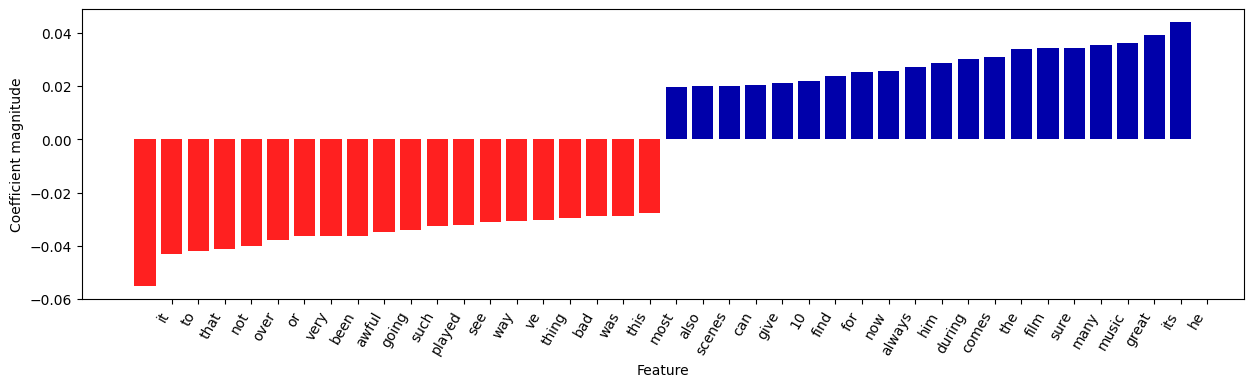

In [29]:
import matplotlib.pyplot as plt

coefs = LogisticRegression(C=0.01).fit(X_train,y_train).coef_
feature_names = vect.get_feature_names_out()

visualize_coefficients(coefs, feature_names, n_top_features=20)

## Bag of words with more than one word (n-grams)

In [30]:
bards_words =["The fool doth think he is wise,",
              "but the wise man knows himself to be a fool"]

print("bards_words:\n{}".format(bards_words))

bards_words:
['The fool doth think he is wise,', 'but the wise man knows himself to be a fool']


In [31]:
cv = CountVectorizer(ngram_range=(1, 1)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names_out()))

Vocabulary size: 13
Vocabulary:
['be' 'but' 'doth' 'fool' 'he' 'himself' 'is' 'knows' 'man' 'the' 'think'
 'to' 'wise']


In [32]:
# Keep bi-grams only

cv = CountVectorizer(ngram_range=(2, 2)).fit(bards_words)

print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names_out()))

Vocabulary size: 14
Vocabulary:
['be fool' 'but the' 'doth think' 'fool doth' 'he is' 'himself to'
 'is wise' 'knows himself' 'man knows' 'the fool' 'the wise' 'think he'
 'to be' 'wise man']


In [33]:
print("Transformed data (dense):\n{}".format(cv.transform(bards_words).toarray()))

Transformed data (dense):
[[0 0 1 1 1 0 1 0 0 1 0 1 0 0]
 [1 1 0 0 0 1 0 1 1 0 1 0 1 1]]


In [34]:
# Keep single words, bi-grams, AND tri-grams

cv = CountVectorizer(ngram_range=(1, 3)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names_out()))

Vocabulary size: 39
Vocabulary:
['be' 'be fool' 'but' 'but the' 'but the wise' 'doth' 'doth think'
 'doth think he' 'fool' 'fool doth' 'fool doth think' 'he' 'he is'
 'he is wise' 'himself' 'himself to' 'himself to be' 'is' 'is wise'
 'knows' 'knows himself' 'knows himself to' 'man' 'man knows'
 'man knows himself' 'the' 'the fool' 'the fool doth' 'the wise'
 'the wise man' 'think' 'think he' 'think he is' 'to' 'to be' 'to be fool'
 'wise' 'wise man' 'wise man knows']


In [35]:
# Fit a model from single words, bi-grams, and tri-grams with tf-idf

vect = TfidfVectorizer(ngram_range=(1,3), min_df=5, norm=None).fit(text_train)
X = vect.transform(text_train)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(LogisticRegression(),param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.63
Best parameters:
{'C': 0.01}


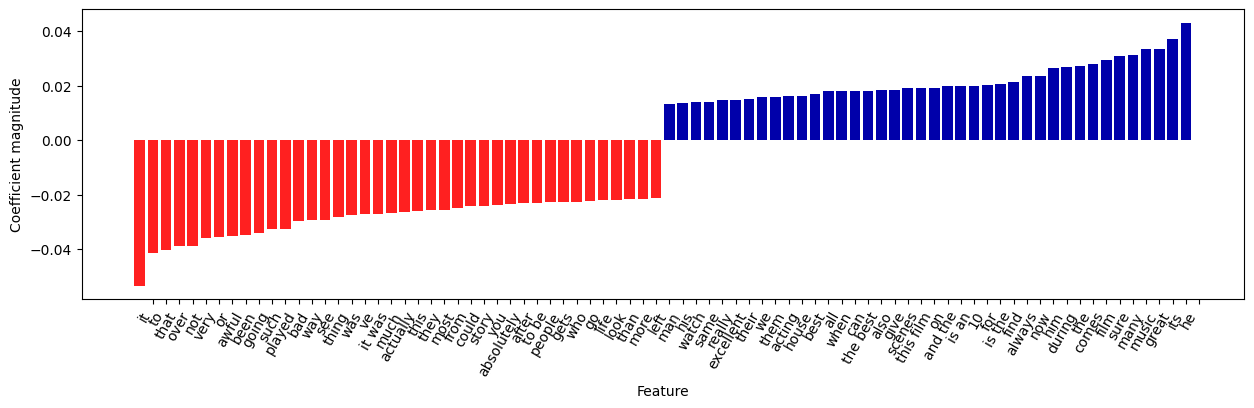

In [36]:
coefs = LogisticRegression(C=0.01).fit(X_train,y_train).coef_
feature_names = vect.get_feature_names_out()

visualize_coefficients(coefs, feature_names, n_top_features=40)

In [37]:
# Find bi-gram and tri-gram features only

vect = TfidfVectorizer(ngram_range=(2,3) ,min_df=3, norm=None).fit(text_train)
X = vect.transform(text_train)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(LogisticRegression(),param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.53
Best parameters:
{'C': 1}


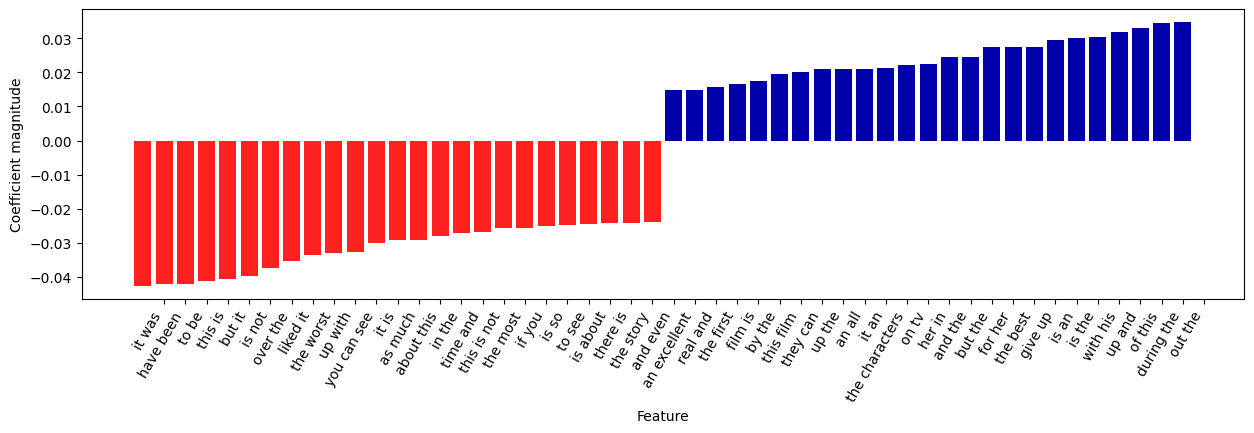

In [38]:
coefs = LogisticRegression(C=0.01).fit(X_train,y_train).coef_
feature_names = vect.get_feature_names_out()

visualize_coefficients(coefs, feature_names, n_top_features=25)

## Advanced tokenization: stemming & lemmatization

In [39]:
# You may or may not need to install nltk first
# ! pip install nltk

In [40]:
# Build the lemmatization object

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate nltk's Porter stemmer
stemmer = nltk.stem.PorterStemmer()

nltk.download('punkt_tab') # may need to update nltk by downloading modules
nltk.download('wordnet') # may need to update nltk by downloading modules

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

# Define a count vectorizer with the custom tokenizer
lemma_vect = CountVectorizer(tokenizer=LemmaTokenizer())

print(lemma_vect.fit(text_train).get_feature_names_out()[::100])

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['!' 'acting' 'arrested' 'bird' 'characteristic' 'core' 'detraction'
 'effort' 'fancy' 'gargling' 'hero' 'intentionally' 'leaping' 'mansion'
 'murdered' 'original' 'possible' 'receive' 'satellite' 'slayer' 'suit'
 'thousand' 'utterly' 'wishi-washi']


In [41]:
# Transform text_train using CountVectorizer with lemmatization

X_lemma = lemma_vect.fit_transform(text_train)

In [42]:
# Train a model on the data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X_lemma, y, random_state=42)
print("X_train.shape: {}".format(X_train.shape))

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(LogisticRegression(), param_grid, cv=10)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.3f}".format(grid.best_score_))

X_train.shape: (30, 2353)
Best cross-validation score: 0.600
